<a href="https://colab.research.google.com/github/Sahanave/WomenWhoCodeHSIDemo/blob/main/HSIDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hyperspectral Images dataset**

Thanking the authors of the paper [Hyperspectral Image Dataset for Benchmarking on Salient Object Detection](https://arxiv.org/abs/1806.11314). 

In [1]:
from pathlib import Path
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import color
import cv2


In [2]:
!pip install chart_studio
import chart_studio.plotly as py
import chart_studio



### Objective

Object detection using supervised or unsupervised approaches on colour images is a huge field. Recently, a few studies demonstrated that efficient salient object detection can also be implemented by using visible spectrum of hyperspectral images. 

**What we have** : A hyperspectral salient object detection dataset with a collection of 60 hyperspectral images with their respective ground-truth binary images and corresponding colour images (sRGB).

Wavelength range : 350 - 1100 nm (151 bands)

Objects : (no description in the paper) : Foreground


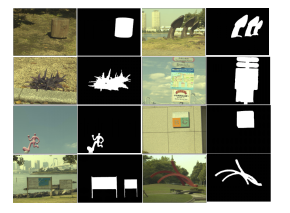

## Dataset 

In [3]:
!wget http://data.airc.aist.go.jp/HS-SOD/HS-SOD.zip
!unzip HS-SOD.zip


URL transformed to HTTPS due to an HSTS policy
--2020-10-26 06:05:11--  https://data.airc.aist.go.jp/HS-SOD/HS-SOD.zip
Resolving data.airc.aist.go.jp (data.airc.aist.go.jp)... 163.220.33.57
Connecting to data.airc.aist.go.jp (data.airc.aist.go.jp)|163.220.33.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5549583419 (5.2G) [application/zip]
Saving to: ‘HS-SOD.zip.3’

HS-SOD.zip.3         15%[==>                 ] 840.05M  68.9MB/s    eta 68s    ^C
Archive:  HS-SOD.zip
replace HS-SOD/LICENSE? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Investigate the labels

In [2]:
 
 Paths = [path for path in Path('HS-SOD').glob('*')]

In [3]:
print(Paths)

[PosixPath('HS-SOD/LICENSE'), PosixPath('HS-SOD/ground_truth'), PosixPath('HS-SOD/color'), PosixPath('HS-SOD/hyperspectral')]


In [4]:
ground_truth =[str(path)for path in Path('HS-SOD/ground_truth').glob('*')]

In [5]:
rgb_images = [str(path) for path in Path('HS-SOD/color').glob('*')]

In [6]:
hsi_images = [str(path) for path in Path('HS-SOD/hyperspectral').glob('*')]

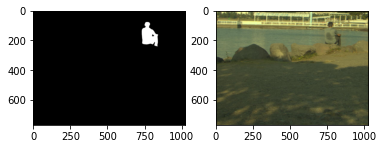

(768, 1024, 3)


In [7]:
image1 = plt.imread(ground_truth[40])
image2 = plt.imread(rgb_images[40])
plt.subplot(1,2,1)
plt.imshow(image1)
plt.subplot(1,2,2)
plt.imshow(image2)
plt.show()
print(image1.shape)

In [8]:
# It is to be noted that the authors did the saved hyper-cubes for each scene in ”.mat” file format after sensor dark-noise correction. 

### `Visualize the bands`



HS-SOD/hyperspectral/0071.mat
(768, 1024)
(768, 1024)
(768, 1024)
(768, 1024)
(768, 1024)
(768, 1024)


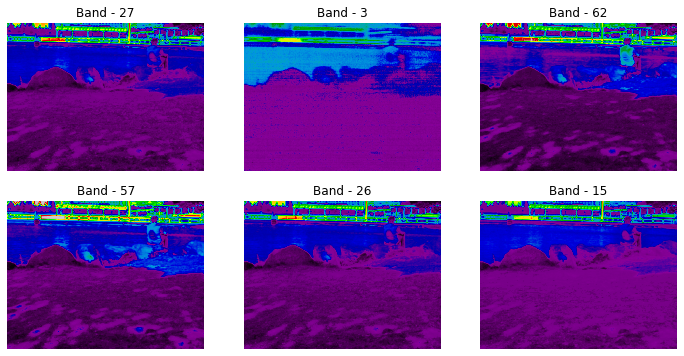

In [9]:
fig = plt.figure(figsize = (12, 6))
with h5py.File('HS-SOD/hyperspectral/0079.mat', 'r') as f:
        print(hsi_images[0])
        data = np.array(f['hypercube'])
        data = np.swapaxes(data,0,2)   
for i in range(1, 1+6):
    fig.add_subplot(2,3, i)
    q = np.random.randint(data.shape[2])
    band_shot = data[:,:,q]
    print(band_shot.shape)
    plt.imshow(band_shot, cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')
plt.show()

# Prepare

In [39]:
def get_pixel_level_dataset(set_of_hsi):
  Complete_data = []
  Label = []
  file_names = []
  for index,inputs in enumerate(set_of_hsi):
    with h5py.File(inputs, 'r') as f:
        file_names.append(inputs)
        data = np.array(f['hypercube'])
        data = np.swapaxes(data,0,2) 
        y=[]
        scale_percent = 50 # percent of original size
        data = np.array(data)
        width = int(data.shape[1] * scale_percent / 100)
        height = int(data.shape[0] * scale_percent / 100)
        dim = (width, height)
        new_data = np.zeros((height,width,data.shape[2]),dtype=np.uint8)
        for i in range(data.shape[2]):
          new_data[:,:,2] = cv2.resize(data[:,:,i],dim)
        new_data = np.array(new_data)
        new_data = new_data.reshape(height*width,data.shape[2])
        GT = plt.imread(ground_truth[index])
        GT = np.array(GT)
        GT = cv2.resize(GT[:,:,0],dim)
        thresh = 127
        GT = cv2.threshold(GT, thresh, 255, cv2.THRESH_BINARY)[1]
        y = GT.reshape(-1)
        Complete_data.extend(new_data)
        Label.extend(y)
  return file_names, Complete_data, Label    
        

In [40]:
filenames, Training_set_X, Training_set_Y = get_pixel_level_dataset(hsi_images[10:30])

**Logistic Regression**

In [41]:
hsi_images[10:30]

['HS-SOD/hyperspectral/0033.mat',
 'HS-SOD/hyperspectral/0076.mat',
 'HS-SOD/hyperspectral/0046.mat',
 'HS-SOD/hyperspectral/0031.mat',
 'HS-SOD/hyperspectral/0026.mat',
 'HS-SOD/hyperspectral/0065.mat',
 'HS-SOD/hyperspectral/0018.mat',
 'HS-SOD/hyperspectral/0029.mat',
 'HS-SOD/hyperspectral/0002.mat',
 'HS-SOD/hyperspectral/0043.mat',
 'HS-SOD/hyperspectral/0036.mat',
 'HS-SOD/hyperspectral/0062.mat',
 'HS-SOD/hyperspectral/0052.mat',
 'HS-SOD/hyperspectral/0028.mat',
 'HS-SOD/hyperspectral/0041.mat',
 'HS-SOD/hyperspectral/0022.mat',
 'HS-SOD/hyperspectral/0020.mat',
 'HS-SOD/hyperspectral/0042.mat',
 'HS-SOD/hyperspectral/0034.mat',
 'HS-SOD/hyperspectral/0079.mat']

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
Training_set_X= np.array(Training_set_X)
print(Training_set_X.shape)
Training_set_Y= np.array(Training_set_Y).reshape(-1)
print(Training_set_Y.shape)
print(set(Training_set_Y))

(3932160, 81)
(3932160,)
{0, 255}


In [44]:
clf = LogisticRegression()
clf.fit(Training_set_X,y=Training_set_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

HS-SOD/hyperspectral/0071.mat


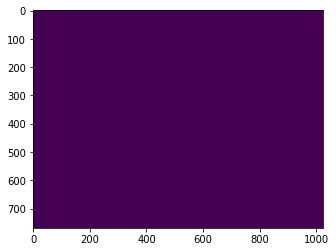

In [50]:
with h5py.File('HS-SOD/hyperspectral/0008.mat', 'r') as f:
        data = np.array(f['hypercube'])
        data = np.swapaxes(data,0,2) 
result = np.zeros((data.shape[0],data.shape[1]),dtype=np.uint8)
for i in range(data.shape[0]):
  for j in range(data.shape[1]):
    result[i,j] = clf.predict(data[i,j,:].reshape(1,-1))
plt.imshow(result)
plt.show()